## Visualizing and Interpreting the Final Model 
This notebook focuses on **visualizing and interpreting the results of the final SVM model** chosen for NBA playoff game prediction.   

---

#### Confusion Matrix  
The confusion matrix is a table that compares the **model’s predictions** against the **true game outcomes**.  

- **Top-left (True Negatives)**: Games where the away team actually won, and the model predicted an away win.  
- **Top-right (False Positives)**: Games where the away team actually won, but the model incorrectly predicted a home win.  
- **Bottom-left (False Negatives)**: Games where the home team actually won, but the model incorrectly predicted an away win.  
- **Bottom-right (True Positives)**: Games where the home team actually won, and the model predicted a home win.  

In this visualization, darker blue squares represent higher counts of games. Ideally, the matrix should be **dark on the diagonal** (correct predictions) and light off-diagonal (errors).  

This chart helps show not just **overall accuracy**, but also **which type of mistake the model makes more often** (predicting home wins incorrectly vs. away wins incorrectly). 

---

- **True Away Wins**: 12 correctly predicted, 24 missed.
- **True Home Wins**: 38 correctly predicted, 10 missed.

The model is very strong at predicting home wins (nearly 80% accuracy there), and captures the natural home-court advantage trend seen in the NBA. However, it struggles with away wins, where predictions are less reliable. This suggests the model is biased toward home wins, a common issue in sports outcome prediction.

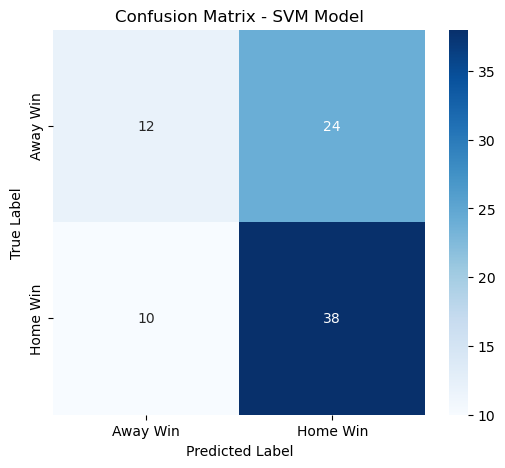

In [85]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Away Win", "Home Win"], yticklabels=["Away Win", "Home Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM Model")
plt.show()

#### Accuracy and F-1 Score by Round
The bar chart below compares the model's performance across playoff rounds using two metrics:

- **Accuracy**: Percentage of correctly predicted games.  
- **F1-Score**: Balances precision (avoiding false positives) and recall (avoiding false negatives), giving a single score for overall predictive quality.  

In sports prediction, accuracy shows how often the model is right, while F1-Score helps us understand whether it handles both wins and losses fairly.

---

**Round 1**: Performance is lower due to early-round unpredictability where upsets are more common.  
- Accuracy: 47%  
- F1-Score: 58%  

**Round 2**: Model improves as stronger teams advance and outcomes become clearer.  
- Accuracy: 74%  
- F1-Score: 75%  

**Round 3**: Predictions stabilize further, with better balance between precision and recall.  
- Accuracy: 73%  
- F1-Score: 84%  

**Round 4**: Strongest results overall, reflecting the model's ability to capture clear matchup dynamics.  
- Accuracy: 71%  
- F1-Score: 83%  

---

##### Key Takeaways:
- The model perofrms better in later rounds as uncertainty decreases.  
- Accuracy improves steadily, and F1 follows the same trend, meaning predictions are not only more correct but also more balanced.  


,round,Accuracy,F1
0,1.0,0.465116,0.581818
1,2.0,0.739130,0.750000
2,3.0,0.727273,0.842105
3,4.0,0.714286,0.833333


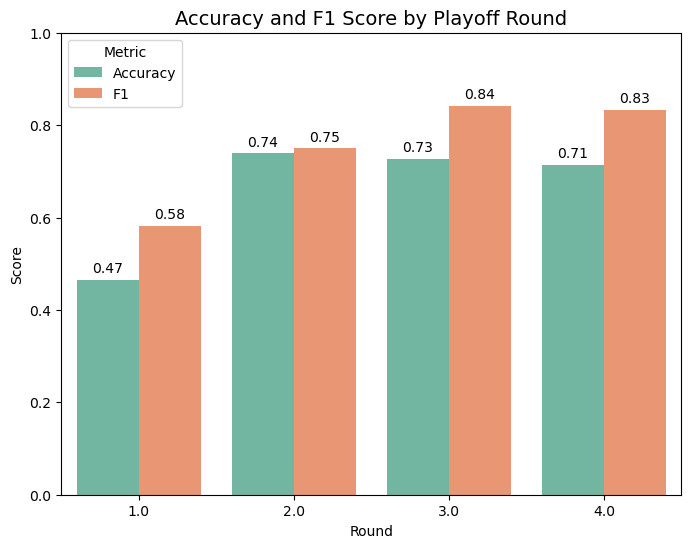

In [166]:
# Import libraries
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
X_test = pd.read_csv("../data/processed/X_test_processed.csv")
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

games = pd.read_csv("../data/processed/playoffs_games.csv")
games = games[games["season"] == 2025].copy()   

# Load trained model
model = joblib.load("../model/final_svm_model.pkl") 

# Make predictions
y_pred = model.predict(X_test)

# Build results dataframe
results = pd.DataFrame({
    "gameId": games["gameId"].values,   
    "round": games["round"].values,
    "true_label": y_test,
    "pred_label": y_pred
})

# Metrics by Round
round_metrics = []
for rnd, group in results.groupby("round"):
    acc = accuracy_score(group["true_label"], group["pred_label"])
    f1 = f1_score(group["true_label"], group["pred_label"])
    round_metrics.append({"round": rnd, "Accuracy": acc, "F1": f1})

round_metrics_df = pd.DataFrame(round_metrics).sort_values("round").reset_index(drop=True)
display(round_metrics_df)

# Visualization
# Convert to long format for seaborn
df_melted = round_metrics_df.melt(
    id_vars="round", value_vars=["Accuracy", "F1"], 
    var_name="metric", value_name="score"
)

plt.figure(figsize=(8,6))
bar = sns.barplot(data=df_melted, x="round", y="score", hue="metric", palette="Set2")

# Add value labels only if > 0
for p in bar.patches:
    value = p.get_height()
    if value > 0:   
        bar.annotate(f"{value:.2f}",
                     (p.get_x() + p.get_width() / 2., value),
                     ha='center', va='bottom',
                     fontsize=10, color="black", xytext=(0, 3),
                     textcoords="offset points")

plt.title("Accuracy and F1 Score by Playoff Round", fontsize=14)
plt.xlabel("Round")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.show()

#### Upset Rate by Round
The chart below shows how often lower-seeded teams beat higher-seeded teams across playoff rounds:
- Upset Rate: Percentage of games where the underdog (lower seed) wins.
- A high upset rate signals unpredictability and makes accurate predictions harder, while a low upset rate means stronger teams are consistently winning.

In playoff basksetball, upsets are most common in early rounds and decrease as matchups become more predictable.

---

**Round 1: Highest unpredictability with frequent upsets**
- Upset Rate: 56%
- Many lower seeds advanced, making predictions more difficult.
  
**Round 2: More stability as stronger teams survive**
- Upset Rate: 26%
- Fewer underdogs won, so predictions became easier.

**Round 3: Continued consistency with reduced randomness**
- Upset Rate: 27%
- Most results aligned with expectations, reflecting stronger model performance.

**Round 4: Finals showcase predictability with only rare upsets.**
- Upset Rate: 29%
- Outcomes were more straightforward, favoring higher seeds.

---
##### Key Takeaways:
- Upsets are most common in Round 1, driving lower accuracy.
- As rounds progress, upset rates fall, making the playoffs more predictable.
- This aligns with the model's improving accuracy and balance in later rounds.

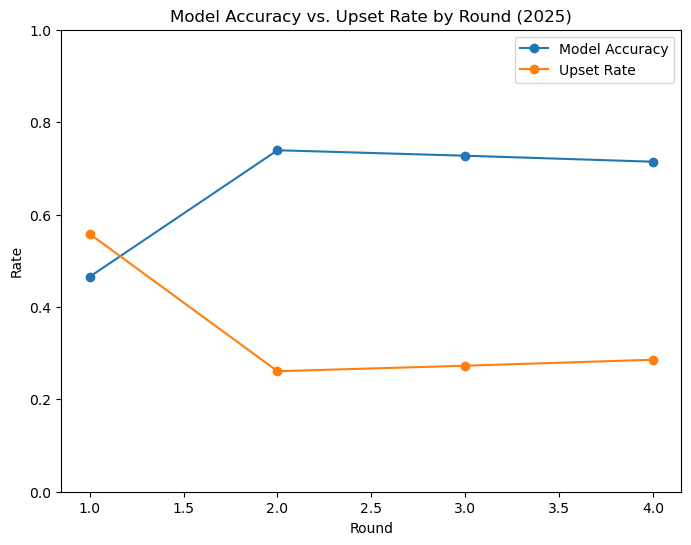

   round  accuracy  upset_rate
0    1.0  0.465116    0.558140
1    2.0  0.739130    0.260870
2    3.0  0.727273    0.272727
3    4.0  0.714286    0.285714


In [186]:
import matplotlib.pyplot as plt

# Compute accuracy and upset rate per round
accuracy_by_round = results.groupby("round").agg(
    accuracy=("pred_label", lambda x: (x == results.loc[x.index, "true_label"]).mean()),
    upset_rate=("is_upset", "mean")
).reset_index()

# Plot
plt.figure(figsize=(8,6))
plt.plot(accuracy_by_round["round"], accuracy_by_round["accuracy"], marker="o", label="Model Accuracy")
plt.plot(accuracy_by_round["round"], accuracy_by_round["upset_rate"], marker="o", label="Upset Rate")
plt.xlabel("Round")
plt.ylabel("Rate")
plt.title("Model Accuracy vs. Upset Rate by Round (2025)")
plt.ylim(0,1)
plt.legend()
plt.show()

print(accuracy_by_round)